In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model

data = pd.read_csv('/content/drive/MyDrive/ADHOC_REPORT_19_09_2023_FY22-23.csv')
#drop na
data = data.dropna()

In [ ]:
print(data.columns)

Index(['DateTime', 'AssetName', 'DataCount',
       ' Temperaturemeasurementforgeneratorbearingnondriveend',
       ' ActualGeneratorphase1temp', ' ActualGeneratorphase2temp',
       ' ActualGeneratorphase3temp', ' Generatorspeed',
       ' Tempingeneratorslipringchamber', ' TotalActivepower',
       ' Totalreactivepower', ' Temperatureoutsidenacelle',
       ' Temperatureinsidenacelle', ' Winddirectionoutsidenacelle',
       ' WindSpeedOutsideNacelle', ' Pitchangle', ' ActualHubcontrollertemp',
       ' RotorSpeed', ' Actualspinnertemperature', ' Actualtopcontrollertemp'],
      dtype='object')


In [ ]:
columns_to_drop = [
    'DateTime',  # Drop date and time since it's not directly related to wind power prediction
    'AssetName',  # Assuming this is an identifier and not directly related to wind power
    'DataCount',  # Assuming it's not relevant for prediction
    ' Totalreactivepower',  # Reactive power is typically not used in wind power prediction
    ' Winddirectionoutsidenacelle',  # Wind direction may not be as relevant as wind speed
    ' Pitchangle',  # Pitch angle may not be as relevant as other variables
    ' ActualHubcontrollertemp',  # Hub controller temperature may not be as relevant
    ' RotorSpeed',  # Depending on your specific use case, rotor speed might be irrelevant
    ' Actualspinnertemperature',  # Spinner temperature may not be as relevant
    ' Actualtopcontrollertemp'  # Top controller temperature may not be as relevant
]

# Drop the columns listed above from the DataFrame
data = data.drop(columns=columns_to_drop)



In [ ]:
data


,Temperaturemeasurementforgeneratorbearingnondriveend,ActualGeneratorphase1temp,ActualGeneratorphase2temp,ActualGeneratorphase3temp,Generatorspeed,Tempingeneratorslipringchamber,TotalActivepower,Temperatureoutsidenacelle,Temperatureinsidenacelle,WindSpeedOutsideNacelle
0,58.20,67.73,67.74,66.47,1453.93,41.00,22984960.0,26.0,35.00,8.17
1,58.06,67.73,68.19,67.26,1449.64,41.00,22985050.0,26.0,35.00,8.21
2,58.00,67.33,67.99,66.99,1416.53,40.99,22985160.0,26.0,35.00,7.87
3,57.87,66.75,66.69,65.95,1485.37,40.54,22985240.0,26.0,35.00,8.20
4,57.59,67.39,68.13,67.07,1410.16,40.66,22985360.0,26.0,34.54,8.13
...,...,...,...,...,...,...,...,...,...,...
105048,53.92,66.74,68.41,69.13,1377.67,43.00,30171490.0,25.0,35.00,7.27
105049,53.00,66.57,69.50,70.66,1452.81,43.00,30171500.0,25.0,35.00,7.92
105050,52.86,67.45,67.60,67.01,1444.43,43.00,30171690.0,25.0,35.00,7.98
105051,52.00,67.27,67.45,66.84,1381.50,42.19,30171690.0,25.0,35.00,7.45


In [ ]:
from sklearn.preprocessing import StandardScaler

# Define the columns to be standardized (excluding the target variable)
columns_to_standardize = data.columns.difference([' TotalActivepower'])  # Exclude the target variable

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Load your preprocessed data
# Assuming your data is in the 'data' DataFrame and already preprocessed

# Split the data into features (X) and target (y)
X = data.drop(columns=[' TotalActivepower'])  # Features
y = data[' TotalActivepower']  # Target variable

# Normalize the target variable (y)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using Min-Max scaling (values between 0 and 1)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Define Parameters
time_steps = 12  # Number of past time steps to consider for prediction
prediction_horizon = 6  # Number of time steps to predict ahead

# Initialize Variables
X_input = X_train_scaled  # Initial input data for training

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Create a learning rate schedule
def lr_schedule(epoch):
    if epoch < 30:
        return 0.001
    elif epoch < 60:
        return 0.0005
    else:
        return 0.0001

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)


# Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model using a sliding window approach
predictions = []

for epoch in range(50):  # Set the number of epochs here
    for i in range(0, len(X_input) - time_steps - prediction_horizon):
        input_sequence = X_input[i:i + time_steps]
        true_value = y_train[i + time_steps + prediction_horizon]  # The true value to predict
        prediction = model.predict(input_sequence.reshape(1, time_steps, X_train_scaled.shape[1]))[0][0]

        # Inverse transform the normalized prediction to original scale
        prediction = scaler_y.inverse_transform(np.array([[prediction]]))

        # Print and reset predictions for the next epoch
        print(f'Epoch {epoch + 1}/{50}, Loss: {model.evaluate(input_sequence.reshape(1, time_steps, X_train_scaled.shape[1]), np.array([true_value]).reshape(1, 1))}')

        print(f'True Value: {true_value}, Predicted Value: {prediction[0][0]}')

# Evaluate the model on the test data
test_loss = model_evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss: {test_loss}')


1/1 [==============================] - 0s 340ms/step - loss: 0.7143
Epoch 1/50, Loss: 0.7143001556396484
True Value: [0.76321777], Predicted Value: -2472420.5
1/1 [==============================] - 0s 29ms/step - loss: 1.0844
Epoch 1/50, Loss: 1.0844240188598633
True Value: [0.96258778], Predicted Value: -2376593.25
1/1 [==============================] - 0s 25ms/step - loss: 1.1412
Epoch 1/50, Loss: 1.1412312984466553
True Value: [0.99001746], Predicted Value: -2361439.75
1/1 [==============================] - 0s 26ms/step - loss: 0.8029
Epoch 1/50, Loss: 0.8029010891914368
True Value: [0.81752895], Predicted Value: -2369036.25
1/1 [==============================] - 0s 26ms/step - loss: 0.7224
Epoch 1/50, Loss: 0.7223699688911438
True Value: [0.77360367], Predicted Value: -2302698.5
1/1 [==============================] - 0s 27ms/step - loss: 1.0862
Epoch 1/50, Loss: 1.0862475633621216
True Value: [0.9661315], Predicted Value: -2296080.5
1/1 [==============================] - 0s 30ms/st

KeyboardInterrupt: ignored

617/617 [==============================] - 2s 3ms/step


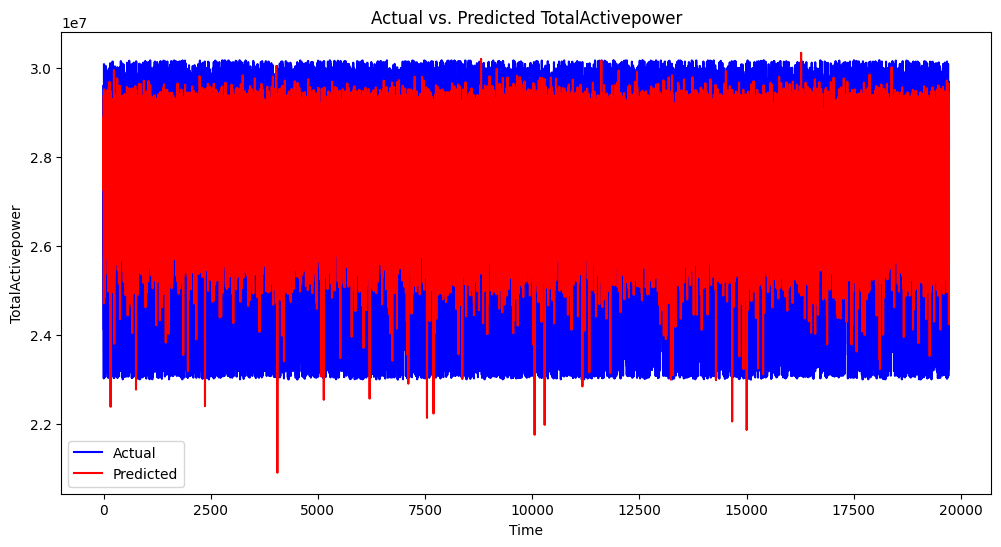

In [ ]:
# Calculate RMSE
y_pred = best_model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred)  # Inverse transform predictions to original scale
y_true = scaler_y.inverse_transform(y_test)  # Inverse transform actual values to original scale

# Plot actual vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs. Predicted TotalActivepower')
plt.xlabel('Time')
plt.ylabel('TotalActivepower')
plt.legend()
plt.show()
